In [ ]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

from zipfile import ZipFile
import os
for i in os.listdir('C:/Users/mehmu/Desktop/PyProjects/Projects/github repo/DiseaseDetection/AlzheimerDataset'):
    if '.zip' in i:
        print(i)
        with ZipFile(i, 'r') as zipObj:
            zipObj.extractall()
        os.remove(i)

In [1]:
import pandas as pd 
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 


import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


# Set the seed value for experiment reproduci.bility.
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')


Num GPUs Available:  1


In [2]:
#define image dataset 
#why do we rescale?
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.33) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     


train_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='Alzheimer_s Dataset/train',
                                                 shuffle=True,
                                                 target_size=(176,208), 
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='Alzheimer_s Dataset/test',
                                                 shuffle=True,
                                                 target_size=(176,208), 
                                                 subset="validation",
                                                 class_mode='categorical')

image_generator_submission = ImageDataGenerator(rescale=1/255) 
submission = image_generator_submission.flow_from_directory(
                                                 directory='Alzheimer_s Dataset/test',
                                                 shuffle=False,
                                                 target_size=(176,208), 
                                                 class_mode=None)


Found 3433 images belonging to 4 classes.
Found 420 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


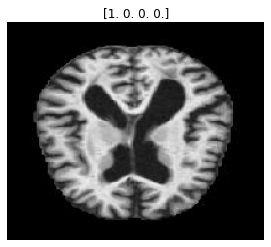

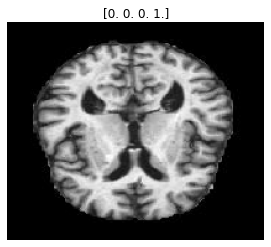

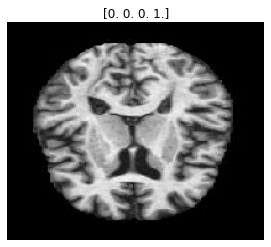

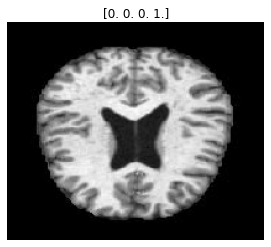

In [3]:
#show flwoers for the first batch

batch_1_img = train_dataset[0]
for i in range(0,4):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()

## CNN

In [4]:
#experiment with Convolutional neural net
model = keras.models.Sequential([
keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = [176,208,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.7),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(4, activation ='softmax')])

In [5]:
model.compile(
        optimizer='adam',
        loss=tensorflow.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.AUC(name='auc'),'acc']
    )

In [6]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_acc',patience=10,restore_best_weights=True)

In [7]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=100
)

Epoch 1/100
430/430 [==============================] - 15s 21ms/step - loss: 1.0995 - auc: 0.7808 - acc: 0.4835 - val_loss: 1.8276 - val_auc: 0.7975 - val_acc: 0.5167 - lr: 0.0100
Epoch 2/100
430/430 [==============================] - 8s 19ms/step - loss: 1.0024 - auc: 0.8030 - acc: 0.4937 - val_loss: 10.9732 - val_auc: 0.6759 - val_acc: 0.5024 - lr: 0.0089
Epoch 3/100
430/430 [==============================] - 9s 20ms/step - loss: 0.9763 - auc: 0.8147 - acc: 0.5200 - val_loss: 0.9476 - val_auc: 0.8212 - val_acc: 0.5048 - lr: 0.0079
Epoch 4/100
430/430 [==============================] - 8s 19ms/step - loss: 0.9653 - auc: 0.8197 - acc: 0.5223 - val_loss: 3.0760 - val_auc: 0.7231 - val_acc: 0.5167 - lr: 0.0071
Epoch 5/100
430/430 [==============================] - 8s 19ms/step - loss: 0.9530 - auc: 0.8250 - acc: 0.5310 - val_loss: 1.1307 - val_auc: 0.6804 - val_acc: 0.3405 - lr: 0.0063
Epoch 6/100
430/430 [==============================] - 8s 19ms/step - loss: 0.9670 - auc: 0.8169 - acc:

In [9]:
loss, auc, accuracy = model.evaluate(validation_dataset)
print("Loss: ", loss)
print("AUC: ", auc)
print("Accuracy: ", accuracy)

53/53 [==============================] - 1s 11ms/step - loss: 0.7599 - auc: 0.8937 - acc: 0.6595
Loss:  0.7598956823348999
AUC:  0.8937349915504456
Accuracy:  0.6595237851142883
